In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                     RepeatedStratifiedKFold,
                                     cross_val_score)

# Feature Selection
from sklearn.feature_selection import RFE

# ML libs
from sklearn.model_selection import train_test_split
from sklearn import metrics                                   

# Models
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  BayesianRidge)

from sklearn.ensemble import (GradientBoostingRegressor,
                              RandomForestRegressor)

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
# Viz libs
import matplotlib.pyplot as plt 

from etl_resources import sqlite_connection

In [2]:
def base_data():
    con = sqlite_connection()
    df = pd.read_sql('select * from training_clean',con=con)
    return df

In [3]:
def residual_plot(y_pred, residuals):
    
    plt.scatter(y_pred, residuals)
    plt.title("residual plot")
    plt.xlabel("price")
    plt.ylabel("residuals")
    plt.axhline(0, color='red')
    plt.show()

In [4]:
def select_features(df):
    
    non_nums = ['date','index','quarter','year','ticker','fiscaldateending','close','close_pct','close_val']
    features = [f for f in df.columns if f not in non_nums]
    
    X = df[features]
    Y = df['close'].values
    #print(features)
    
    return X, Y

In [5]:
def feature_select_recursive(X, Y, model, name):
        
    rfe = RFE(model)
    
    rfe = rfe.fit(X, Y)
    
    cols = list(X.columns)
    features = pd.Series(rfe.support_,index = cols)
    
    selected_features_rfe = features[features==True].index.tolist()
    
    print('\n')
    print('Selected Features for:', name)
    print(selected_features_rfe)
    print('\n')

    return selected_features_rfe


In [6]:
def profile_data():
    
    con = sqlite_connection()
    
    qry = '''select * from training'''
    
    df = pd.read_sql(qry, con=con)
    
    profile = ProfileReport(df, title='training profile')
    profile.to_file('../data/profiles/pre-training.html')

In [7]:
def model_selection():
    
    df = base_data()
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    models = list()
    
    # Try these models first
    models.append(('GBR', GradientBoostingRegressor())) 
    models.append(('RFR',RandomForestRegressor(n_jobs=-1))) 
    models.append(('MLR', LinearRegression()))
    models.append(('Ridge', Ridge()))
    models.append(('Bayes Ridge', BayesianRidge()))
    models.append(('KNN',KNeighborsRegressor()))
    models.append(('Decision Tree',DecisionTreeRegressor(max_depth=1)))
    models.append(('SVM',SVR()))
    
    for name, model in models:
        
        print('\n{}'.format(name))
        print('------------------------------------------------------')
        print('------------------------------------------------------')
        
        # Split out X, Y
        
        X,Y = select_features(df)
        
        if name not in ['KNN','SVM']:
            
            features = feature_select_recursive(X, Y, model, name)
        
            # Apply the feature selection
            X = X[features]
        
        # Break out train and test sets (using 80% train 20% test)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
        
        # Fit the model to the training split
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
                
        print('Regression Metrics:')
        scores = {
        'mean_squared_error':metrics.mean_squared_error(y_test, y_pred).round(2),
        'root_mean_squared_error': np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2),
        'mean_absolute_error':metrics.mean_absolute_error(y_test, y_pred).round(2),
        'explained_variance_score':metrics.explained_variance_score(y_test, y_pred).round(2),
        'r2_score':metrics.r2_score(y_test, y_pred).round(2)
        }
        
        for metric, score in scores.items():
            print(metric+':', score)
        
        residuals = y_test-y_pred
        
        residual_plot(y_pred, residuals)
        
        #print('\nWriting out {} to disk'.format(name))
        #filename = 'models/{}.sav'.format(name)
        #pickle.dump(model, open(filename, 'wb'))
        
        print('\n------------------------------------------------------')


GBR
------------------------------------------------------
------------------------------------------------------


Selected Features for: GBR
['totalassets', 'totalcurrentassets', 'cashandcashequivalentsatcarryingvalue', 'cashandshortterminvestments', 'inventory', 'currentnetreceivables', 'totalnoncurrentassets', 'propertyplantequipment', 'accumulateddepreciationamortizationppe', 'intangibleassets', 'intangibleassetsexcludinggoodwill', 'goodwill', 'investments', 'longterminvestments', 'shortterminvestments', 'othercurrentassets', 'othernoncurrrentassets', 'totalliabilities', 'totalcurrentliabilities', 'currentaccountspayable', 'deferredrevenue', 'shorttermdebt', 'totalnoncurrentliabilities', 'capitalleaseobligations', 'longtermdebtnoncurrent', 'shortlongtermdebttotal', 'othernoncurrentliabilities', 'totalshareholderequity', 'treasurystock', 'retainedearnings', 'commonstock', 'commonstocksharesoutstanding', 'totalassets_pct', 'cashandcashequivalentsatcarryingvalue_pct', 'inventory_pct

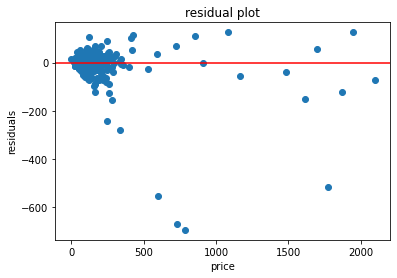


------------------------------------------------------

RFR
------------------------------------------------------
------------------------------------------------------


Selected Features for: RFR
['totalassets', 'totalcurrentassets', 'cashandcashequivalentsatcarryingvalue', 'cashandshortterminvestments', 'inventory', 'currentnetreceivables', 'totalnoncurrentassets', 'propertyplantequipment', 'accumulateddepreciationamortizationppe', 'intangibleassets', 'intangibleassetsexcludinggoodwill', 'goodwill', 'investments', 'longterminvestments', 'shortterminvestments', 'othercurrentassets', 'othernoncurrrentassets', 'totalliabilities', 'totalcurrentliabilities', 'currentaccountspayable', 'deferredrevenue', 'currentdebt', 'shorttermdebt', 'totalnoncurrentliabilities', 'capitalleaseobligations', 'longtermdebt', 'currentlongtermdebt', 'longtermdebtnoncurrent', 'shortlongtermdebttotal', 'othercurrentliabilities', 'othernoncurrentliabilities', 'totalshareholderequity', 'treasurystock', 'retaine

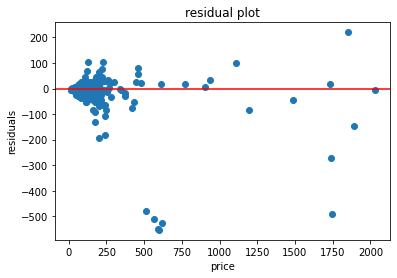


------------------------------------------------------

MLR
------------------------------------------------------
------------------------------------------------------


Selected Features for: MLR
['totalassets', 'totalcurrentassets', 'cashandshortterminvestments', 'propertyplantequipment', 'accumulateddepreciationamortizationppe', 'intangibleassets', 'intangibleassetsexcludinggoodwill', 'goodwill', 'investments', 'shortterminvestments', 'othernoncurrrentassets', 'totalliabilities', 'currentaccountspayable', 'currentdebt', 'shorttermdebt', 'totalnoncurrentliabilities', 'capitalleaseobligations', 'longtermdebt', 'currentlongtermdebt', 'longtermdebtnoncurrent', 'shortlongtermdebttotal', 'othercurrentliabilities', 'totalshareholderequity', 'treasurystock', 'retainedearnings', 'commonstock', 'commonstocksharesoutstanding', 'totalassets_pct', 'accumulateddepreciationamortizationppe_pct', 'totalassets_val', 'totalcurrentassets_val', 'cashandcashequivalentsatcarryingvalue_val', 'cashandsho

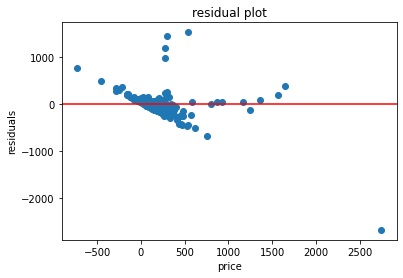


------------------------------------------------------

Ridge
------------------------------------------------------
------------------------------------------------------


Selected Features for: Ridge
['totalcurrentassets', 'cashandcashequivalentsatcarryingvalue', 'cashandshortterminvestments', 'currentnetreceivables', 'propertyplantequipment', 'accumulateddepreciationamortizationppe', 'intangibleassets', 'intangibleassetsexcludinggoodwill', 'goodwill', 'longterminvestments', 'shortterminvestments', 'othercurrentassets', 'othernoncurrrentassets', 'currentaccountspayable', 'deferredrevenue', 'currentdebt', 'shorttermdebt', 'totalnoncurrentliabilities', 'capitalleaseobligations', 'longtermdebt', 'currentlongtermdebt', 'longtermdebtnoncurrent', 'shortlongtermdebttotal', 'othercurrentliabilities', 'othernoncurrentliabilities', 'totalshareholderequity', 'retainedearnings', 'commonstock', 'commonstocksharesoutstanding', 'totalassets_pct', 'accumulateddepreciationamortizationppe_pct', 'cur

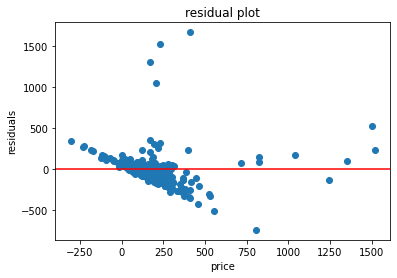


------------------------------------------------------

Bayes Ridge
------------------------------------------------------
------------------------------------------------------


Selected Features for: Bayes Ridge
['totalassets', 'totalcurrentassets', 'cashandshortterminvestments', 'currentnetreceivables', 'propertyplantequipment', 'accumulateddepreciationamortizationppe', 'intangibleassets', 'intangibleassetsexcludinggoodwill', 'goodwill', 'longterminvestments', 'shortterminvestments', 'totalliabilities', 'currentaccountspayable', 'shorttermdebt', 'totalnoncurrentliabilities', 'capitalleaseobligations', 'longtermdebt', 'shortlongtermdebttotal', 'othercurrentliabilities', 'othernoncurrentliabilities', 'totalshareholderequity', 'treasurystock', 'retainedearnings', 'commonstock', 'commonstocksharesoutstanding', 'cashandcashequivalentsatcarryingvalue_pct', 'cashandshortterminvestments_pct', 'currentnetreceivables_pct', 'totalnoncurrentassets_pct', 'propertyplantequipment_pct', 'accumula

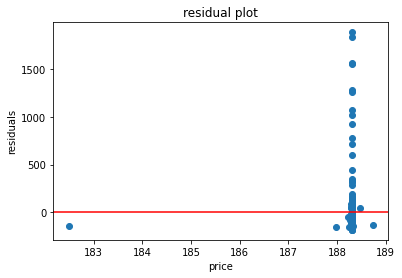


------------------------------------------------------

KNN
------------------------------------------------------
------------------------------------------------------
Regression Metrics:
mean_squared_error: 75745.78
root_mean_squared_error: 275.22
mean_absolute_error: 154.28
explained_variance_score: -0.02
r2_score: -0.05


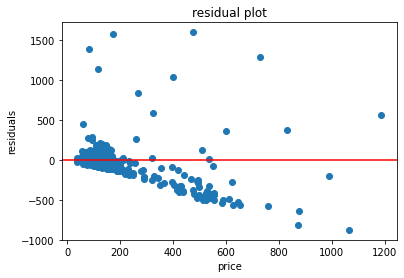


------------------------------------------------------

Decision Tree
------------------------------------------------------
------------------------------------------------------


Selected Features for: Decision Tree
['proceedsfromoperatingactivities_pct', 'changeinoperatingliabilities_pct', 'changeinoperatingassets_pct', 'depreciationdepletionandamortization_pct', 'capitalexpenditures_pct', 'changeinreceivables_pct', 'changeininventory_pct', 'profitloss_pct', 'cashflowfrominvestment_pct', 'cashflowfromfinancing_pct', 'proceedsfromrepaymentsofshorttermdebt_pct', 'paymentsforrepurchaseofcommonstock_pct', 'paymentsforrepurchaseofequity_pct', 'paymentsforrepurchaseofpreferredstock_pct', 'dividendpayout_pct', 'dividendpayoutcommonstock_pct', 'dividendpayoutpreferredstock_pct', 'proceedsfromissuanceofcommonstock_pct', 'proceedsfromissuanceoflongtermdebtandcapitalsecuritiesnet_pct', 'proceedsfromissuanceofpreferredstock_pct', 'proceedsfromrepurchaseofequity_pct', 'proceedsfromsaleoftreasu

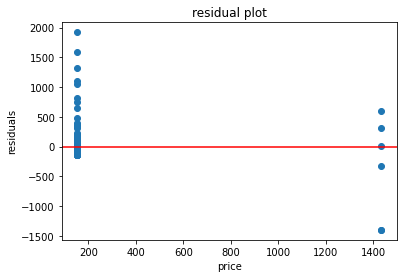


------------------------------------------------------

SVM
------------------------------------------------------
------------------------------------------------------
Regression Metrics:
mean_squared_error: 77115.01
root_mean_squared_error: 277.7
mean_absolute_error: 108.84
explained_variance_score: -0.0
r2_score: -0.07


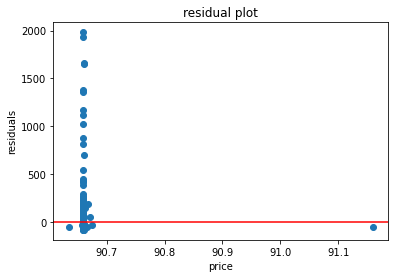


------------------------------------------------------


In [8]:
model_selection()